In [2]:
# Import depencies
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from config import db_password
import seaborn as sns
import psycopg2

## Take a look of the data

In [44]:
# Read data from csv file
raw_df=pd.read_csv("Resources/Airline_Satisfaction_train.csv", index_col=0)
raw_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [45]:
# Replace spaces in the column names with '_'
raw_df.columns = [c.replace(' ','_') for c in raw_df.columns]

In [46]:
# Check the basic info of the dataframe
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer_Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type_of_Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight_Distance                    103904 non-null  int64  
 7   Inflight_wifi_service              103904 non-null  int64  
 8   Departure/Arrival_time_convenient  103904 non-null  int64  
 9   Ease_of_Online_booking             103904 non-null  int64  
 10  Gate_location                      103904 non-null  int64  
 11  Food_and_drink                     1039

In [47]:
raw_df.isnull().sum()

id                                     0
Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
dtype: int64

There are 310 missing values in the Arrival Delay in Minutes column
id column does not have an impact to customer satisfaction results, it can be removed
There are several columns with text values. We need to transform these text values into numerical data before we fit the data into the prediction model. 

In [48]:
# Drop id column
raw_df = raw_df.drop('id', axis=1)
raw_df.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Fill missing values

In [49]:
# Describe the Arrival_Delay_in_Minutes column
raw_df['Arrival_Delay_in_Minutes'].describe()

count    103594.000000
mean         15.178678
std          38.698682
min           0.000000
25%           0.000000
50%           0.000000
75%          13.000000
max        1584.000000
Name: Arrival_Delay_in_Minutes, dtype: float64

In [51]:
# Calculate % of missing values in the Arrival_Delay_in_Minutes column
missing_count=raw_df['Arrival_Delay_in_Minutes'].isnull().sum()
total= raw_df['Arrival_Delay_in_Minutes'].count()
pct_missing=missing_count/total
pct_missing

0.0029924513002683555

In [52]:
# Fill null values with median in Arrival Delay in Minutes column
raw_df['Arrival_Delay_in_Minutes']=raw_df['Arrival_Delay_in_Minutes'].fillna(raw_df['Arrival_Delay_in_Minutes'].median())
raw_df['Arrival_Delay_in_Minutes'].isnull().sum()

0

In [53]:
# Describe the dataframe
raw_df.describe()

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


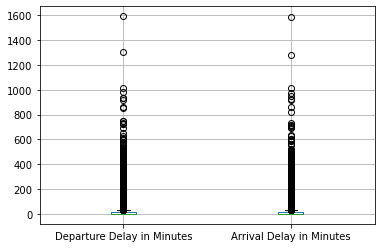

In [22]:
# Boxplot the Departure Delay in Minutes and Arrival Delay in Minutes columns
boxplot = df_fillnull.boxplot(column=['Departure Delay in Minutes', "Arrival Delay in Minutes"])

In [13]:
# # IQR
# Departure_IQR = 12.0-0.0
# Departure_upperbond= Departure_IQR*1.5 + 12.0
# Departure_upperbond

30.0

In [18]:
# Count flights with departure delay higher than upperbond
Count_departure_delay_outliner= raw_df[raw_df['Departure Delay in Minutes']>Departure_upperbond].count()
Count_departure_delay_outliner

id                                   14529
Gender                               14529
Customer Type                        14529
Age                                  14529
Type of Travel                       14529
Class                                14529
Flight Distance                      14529
Inflight wifi service                14529
Departure/Arrival time convenient    14529
Ease of Online booking               14529
Gate location                        14529
Food and drink                       14529
Online boarding                      14529
Seat comfort                         14529
Inflight entertainment               14529
On-board service                     14529
Leg room service                     14529
Baggage handling                     14529
Checkin service                      14529
Inflight service                     14529
Cleanliness                          14529
Departure Delay in Minutes           14529
Arrival Delay in Minutes             14428
satisfactio